# **Training notebook**

Dentro de este notebook desglosamos el entrenamiento de nuestro modelo de SRGAN

## Importamos archivos

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Creamos las funciones necesarias

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.utils.data import Dataset

import os
from PIL import Image
import numpy as np
import random


from skimage.color import rgb2ycbcr
from skimage.metrics import peak_signal_noise_ratio as compare_pnsr


import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
class MeanShift(nn.Conv2d):
    def __init__(
        self, rgb_range = 1,
        norm_mean=(0.485, 0.456, 0.406), norm_std=(0.229, 0.224, 0.225), sign=-1):

        super(MeanShift, self).__init__(3, 3, kernel_size=1)
        std = torch.Tensor(norm_std)
        self.weight.data = torch.eye(3).view(3, 3, 1, 1) / std.view(3, 1, 1, 1)
        self.bias.data = sign * rgb_range * torch.Tensor(norm_mean) / std
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        for p in self.parameters():
            p.requires_grad = False


class perceptual_loss(nn.Module):

    def __init__(self, vgg):
        super(perceptual_loss, self).__init__()
        self.normalization_mean = [0.485, 0.456, 0.406]
        self.normalization_std = [0.229, 0.224, 0.225]
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.transform = MeanShift(norm_mean = self.normalization_mean, norm_std = self.normalization_std).to(self.device)
        self.vgg = vgg
        self.criterion = nn.MSELoss()
    def forward(self, HR, SR, layer = 'relu5_4'):
        ## HR and SR should be normalized [0,1]
        hr = self.transform(HR)
        sr = self.transform(SR)
        
        hr_feat = getattr(self.vgg(hr), layer)
        sr_feat = getattr(self.vgg(sr), layer)
        
        return self.criterion(hr_feat, sr_feat), hr_feat, sr_feat

class TVLoss(nn.Module):
    def __init__(self, tv_loss_weight=1):
        super(TVLoss, self).__init__()
        self.tv_loss_weight = tv_loss_weight

    def forward(self, x):
        batch_size = x.size()[0]
        h_x = x.size()[2]
        w_x = x.size()[3]
        count_h = self.tensor_size(x[:, :, 1:, :])
        count_w = self.tensor_size(x[:, :, :, 1:])
        h_tv = torch.pow((x[:, :, 1:, :] - x[:, :, :h_x - 1, :]), 2).sum()
        w_tv = torch.pow((x[:, :, :, 1:] - x[:, :, :, :w_x - 1]), 2).sum()
        
        return self.tv_loss_weight * 2 * (h_tv / count_h + w_tv / count_w) / batch_size

    @staticmethod
    def tensor_size(t):
        return t.size()[1] * t.size()[2] * t.size()[3]


In [ ]:
class mydata(Dataset):
    def __init__(self, LR_path, GT_path, in_memory = True, transform = None):
        
        self.LR_path = LR_path
        self.GT_path = GT_path
        self.in_memory = in_memory
        self.transform = transform
        
        self.LR_img = sorted(os.listdir(LR_path))
        self.GT_img = sorted(os.listdir(GT_path))
        
        if in_memory:
            self.LR_img = [np.array(Image.open(os.path.join(self.LR_path, lr)).convert("RGB")).astype(np.uint8) for lr in self.LR_img]
            self.GT_img = [np.array(Image.open(os.path.join(self.GT_path, gt)).convert("RGB")).astype(np.uint8) for gt in self.GT_img]
        
    def __len__(self):
        
        return len(self.LR_img)
        
    def __getitem__(self, i):
        
        img_item = {}
        
        if self.in_memory:
            GT = self.GT_img[i].astype(np.float32)
            LR = self.LR_img[i].astype(np.float32)
            
        else:
            GT = np.array(Image.open(os.path.join(self.GT_path, self.GT_img[i])).convert("RGB"))
            LR = np.array(Image.open(os.path.join(self.LR_path, self.LR_img[i])).convert("RGB"))

        img_item['GT'] = (GT / 127.5) - 1.0
        img_item['LR'] = (LR / 127.5) - 1.0
                
        if self.transform is not None:
            img_item = self.transform(img_item)
            
        img_item['GT'] = img_item['GT'].transpose(2, 0, 1).astype(np.float32)
        img_item['LR'] = img_item['LR'].transpose(2, 0, 1).astype(np.float32)
        
        return img_item
    
    
class testOnly_data(Dataset):
    def __init__(self, LR_path, in_memory = True, transform = None):
        
        self.LR_path = LR_path
        self.LR_img = sorted(os.listdir(LR_path))
        self.in_memory = in_memory
        if in_memory:
            self.LR_img = [np.array(Image.open(os.path.join(self.LR_path, lr))) for lr in self.LR_img]
        
    def __len__(self):
        
        return len(self.LR_img)
        
    def __getitem__(self, i):
        
        img_item = {}
        
        if self.in_memory:
            LR = self.LR_img[i]
            
        else:
            LR = np.array(Image.open(os.path.join(self.LR_path, self.LR_img[i])))

        img_item['LR'] = (LR / 127.5) - 1.0                
        img_item['LR'] = img_item['LR'].transpose(2, 0, 1).astype(np.float32)
        
        return img_item


class crop(object):
    def __init__(self, scale, patch_size):
        
        self.scale = scale
        self.patch_size = patch_size
        
    def __call__(self, sample):
        LR_img, GT_img = sample['LR'], sample['GT']
        ih, iw = LR_img.shape[:2]
        
        ix = random.randrange(0, iw - self.patch_size +1)
        iy = random.randrange(0, ih - self.patch_size +1)
        
        tx = ix * self.scale
        ty = iy * self.scale
        
        LR_patch = LR_img[iy : iy + self.patch_size, ix : ix + self.patch_size]
        GT_patch = GT_img[ty : ty + (self.scale * self.patch_size), tx : tx + (self.scale * self.patch_size)]
        
        return {'LR' : LR_patch, 'GT' : GT_patch}

class augmentation(object):
    
    def __call__(self, sample):
        LR_img, GT_img = sample['LR'], sample['GT']
        
        hor_flip = random.randrange(0,2)
        ver_flip = random.randrange(0,2)
        rot = random.randrange(0,2)
    
        if hor_flip:
            temp_LR = np.fliplr(LR_img)
            LR_img = temp_LR.copy()
            temp_GT = np.fliplr(GT_img)
            GT_img = temp_GT.copy()
            
            del temp_LR, temp_GT
        
        if ver_flip:
            temp_LR = np.flipud(LR_img)
            LR_img = temp_LR.copy()
            temp_GT = np.flipud(GT_img)
            GT_img = temp_GT.copy()
            
            del temp_LR, temp_GT
            
        if rot:
            LR_img = LR_img.transpose(1, 0, 2)
            GT_img = GT_img.transpose(1, 0, 2)
        
        
        return {'LR' : LR_img, 'GT' : GT_img}
        



In [ ]:

import torch.nn.functional as F


class _conv(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, bias):
        super(_conv, self).__init__(in_channels = in_channels, out_channels = out_channels, 
                               kernel_size = kernel_size, stride = stride, padding = (kernel_size) // 2, bias = True)
        
        self.weight.data = torch.normal(torch.zeros((out_channels, in_channels, kernel_size, kernel_size)), 0.02)
        self.bias.data = torch.zeros((out_channels))
        
        for p in self.parameters():
            p.requires_grad = True
        

class conv(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size, BN = False, act = None, stride = 1, bias = True):
        super(conv, self).__init__()
        m = []
        m.append(_conv(in_channels = in_channel, out_channels = out_channel, 
                               kernel_size = kernel_size, stride = stride, padding = (kernel_size) // 2, bias = True))
        
        if BN:
            m.append(nn.BatchNorm2d(num_features = out_channel))
        
        if act is not None:
            m.append(act)
        
        self.body = nn.Sequential(*m)
        
    def forward(self, x):
        out = self.body(x)
        return out
        
class ResBlock(nn.Module):
    def __init__(self, channels, kernel_size, act = nn.ReLU(inplace = True), bias = True):
        super(ResBlock, self).__init__()
        m = []
        m.append(conv(channels, channels, kernel_size, BN = True, act = act))
        m.append(conv(channels, channels, kernel_size, BN = True, act = None))
        self.body = nn.Sequential(*m)
        
    def forward(self, x):
        res = self.body(x)
        res += x
        return res
    
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, num_res_block, act = nn.ReLU(inplace = True)):
        super(BasicBlock, self).__init__()
        m = []
        
        self.conv = conv(in_channels, out_channels, kernel_size, BN = False, act = act)
        for i in range(num_res_block):
            m.append(ResBlock(out_channels, kernel_size, act))
        
        m.append(conv(out_channels, out_channels, kernel_size, BN = True, act = None))
        
        self.body = nn.Sequential(*m)
        
    def forward(self, x):
        res = self.conv(x)
        out = self.body(res)
        out += res
        
        return out
        
class Upsampler(nn.Module):
    def __init__(self, channel, kernel_size, scale, act = nn.ReLU(inplace = True)):
        super(Upsampler, self).__init__()
        m = []
        m.append(conv(channel, channel * scale * scale, kernel_size))
        m.append(nn.PixelShuffle(scale))
    
        if act is not None:
            m.append(act)
        
        self.body = nn.Sequential(*m)
    
    def forward(self, x):
        out = self.body(x)
        return out

class discrim_block(nn.Module):
    def __init__(self, in_feats, out_feats, kernel_size, act = nn.LeakyReLU(inplace = True)):
        super(discrim_block, self).__init__()
        m = []
        m.append(conv(in_feats, out_feats, kernel_size, BN = True, act = act))
        m.append(conv(out_feats, out_feats, kernel_size, BN = True, act = act, stride = 2))
        self.body = nn.Sequential(*m)
        
    def forward(self, x):
        out = self.body(x)
        return out

In [ ]:
class Generator(nn.Module):
    
    def __init__(self, img_feat = 3, n_feats = 64, kernel_size = 3, num_block = 16, act = nn.PReLU(), scale=4):
        super(Generator, self).__init__()
        
        self.conv01 = conv(in_channel = img_feat, out_channel = n_feats, kernel_size = 9, BN = False, act = act)
        
        resblocks = [ResBlock(channels = n_feats, kernel_size = 3, act = act) for _ in range(num_block)]
        self.body = nn.Sequential(*resblocks)
        
        self.conv02 = conv(in_channel = n_feats, out_channel = n_feats, kernel_size = 3, BN = True, act = None)
        
        if(scale == 4):
            upsample_blocks = [Upsampler(channel = n_feats, kernel_size = 3, scale = 2, act = act) for _ in range(2)]
        else:
            upsample_blocks = [Upsampler(channel = n_feats, kernel_size = 3, scale = scale, act = act)]

        self.tail = nn.Sequential(*upsample_blocks)
        
        self.last_conv = conv(in_channel = n_feats, out_channel = img_feat, kernel_size = 3, BN = False, act = nn.Tanh())
        
    def forward(self, x):
        
        x = self.conv01(x)
        _skip_connection = x
        
        x = self.body(x)
        x = self.conv02(x)
        feat = x + _skip_connection
        
        x = self.tail(feat)
        x = self.last_conv(x)
        
        return x, feat
    
class Discriminator(nn.Module):
    
    def __init__(self, img_feat = 3, n_feats = 64, kernel_size = 3, act = nn.LeakyReLU(inplace = True), num_of_block = 3, patch_size = 96):
        super(Discriminator, self).__init__()
        self.act = act
        
        self.conv01 = conv(in_channel = img_feat, out_channel = n_feats, kernel_size = 3, BN = False, act = self.act)
        self.conv02 = conv(in_channel = n_feats, out_channel = n_feats, kernel_size = 3, BN = False, act = self.act, stride = 2)
        
        body = [discrim_block(in_feats = n_feats * (2 ** i), out_feats = n_feats * (2 ** (i + 1)), kernel_size = 3, act = self.act) for i in range(num_of_block)]    
        self.body = nn.Sequential(*body)
        
        self.linear_size = ((patch_size // (2 ** (num_of_block + 1))) ** 2) * (n_feats * (2 ** num_of_block))
        
        tail = []
        
        tail.append(nn.Linear(self.linear_size, 1024))
        tail.append(self.act)
        tail.append(nn.Linear(1024, 1))
        tail.append(nn.Sigmoid())
        
        self.tail = nn.Sequential(*tail)
        
        
    def forward(self, x):
        
        x = self.conv01(x)
        x = self.conv02(x)
        x = self.body(x)        
        x = x.view(-1, self.linear_size)
        x = self.tail(x)
        
        return x



from torchvision import models
from collections import namedtuple
import torch
import torch.nn as nn


class vgg19(nn.Module):
    
    def __init__(self, pre_trained = True, require_grad = False):
        super(vgg19, self).__init__()
        self.vgg_feature = models.vgg19(pretrained = pre_trained).features
        self.seq_list = [nn.Sequential(ele) for ele in self.vgg_feature]
        self.vgg_layer = ['conv1_1', 'relu1_1', 'conv1_2', 'relu1_2', 'pool1', 
                         'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'pool2',
                         'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 'conv3_3', 'relu3_3', 'conv3_4', 'relu3_4', 'pool3',
                         'conv4_1', 'relu4_1', 'conv4_2', 'relu4_2', 'conv4_3', 'relu4_3', 'conv4_4', 'relu4_4', 'pool4',
                         'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2', 'conv5_3', 'relu5_3', 'conv5_4', 'relu5_4', 'pool5']
        
        if not require_grad:
            for parameter in self.parameters():
                parameter.requires_grad = False
        
    def forward(self, x):
        
        conv1_1 = self.seq_list[0](x)
        relu1_1 = self.seq_list[1](conv1_1)
        conv1_2 = self.seq_list[2](relu1_1)
        relu1_2 = self.seq_list[3](conv1_2)
        pool1 = self.seq_list[4](relu1_2)
        
        conv2_1 = self.seq_list[5](pool1)
        relu2_1 = self.seq_list[6](conv2_1)
        conv2_2 = self.seq_list[7](relu2_1)
        relu2_2 = self.seq_list[8](conv2_2)
        pool2 = self.seq_list[9](relu2_2)
        
        conv3_1 = self.seq_list[10](pool2)
        relu3_1 = self.seq_list[11](conv3_1)
        conv3_2 = self.seq_list[12](relu3_1)
        relu3_2 = self.seq_list[13](conv3_2)
        conv3_3 = self.seq_list[14](relu3_2)
        relu3_3 = self.seq_list[15](conv3_3)
        conv3_4 = self.seq_list[16](relu3_3)
        relu3_4 = self.seq_list[17](conv3_4)
        pool3 = self.seq_list[18](relu3_4)
        
        conv4_1 = self.seq_list[19](pool3)
        relu4_1 = self.seq_list[20](conv4_1)
        conv4_2 = self.seq_list[21](relu4_1)
        relu4_2 = self.seq_list[22](conv4_2)
        conv4_3 = self.seq_list[23](relu4_2)
        relu4_3 = self.seq_list[24](conv4_3)
        conv4_4 = self.seq_list[25](relu4_3)
        relu4_4 = self.seq_list[26](conv4_4)
        pool4 = self.seq_list[27](relu4_4)
        
        conv5_1 = self.seq_list[28](pool4)
        relu5_1 = self.seq_list[29](conv5_1)
        conv5_2 = self.seq_list[30](relu5_1)
        relu5_2 = self.seq_list[31](conv5_2)
        conv5_3 = self.seq_list[32](relu5_2)
        relu5_3 = self.seq_list[33](conv5_3)
        conv5_4 = self.seq_list[34](relu5_3)
        relu5_4 = self.seq_list[35](conv5_4)
        pool5 = self.seq_list[36](relu5_4)
        
        vgg_output = namedtuple("vgg_output", self.vgg_layer)
        
        vgg_list = [conv1_1, relu1_1, conv1_2, relu1_2, pool1, 
                         conv2_1, relu2_1, conv2_2, relu2_2, pool2,
                         conv3_1, relu3_1, conv3_2, relu3_2, conv3_3, relu3_3, conv3_4, relu3_4, pool3,
                         conv4_1, relu4_1, conv4_2, relu4_2, conv4_3, relu4_3, conv4_4, relu4_4, pool4,
                         conv5_1, relu5_1, conv5_2, relu5_2, conv5_3, relu5_3, conv5_4, relu5_4, pool5]
        
        out = vgg_output(*vgg_list)
        
        
        return out

In [ ]:
def train(args):

    losses = []
    epochs = []
    progress_bar = iter(tqdm(range(args.pre_train_epoch)))
    

    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    transform  = transforms.Compose([crop(args.scale, args.patch_size), augmentation()])
    dataset = mydata(GT_path = args.GT_path, LR_path = args.LR_path, in_memory = args.in_memory, transform = transform)
    loader = DataLoader(dataset, batch_size = args.batch_size, shuffle = True, num_workers = args.num_workers)
    
    generator = Generator(img_feat = 3, n_feats = 64, kernel_size = 3, num_block = args.res_num, scale=args.scale)
    
    
    if args.fine_tuning:        
        generator.load_state_dict(torch.load(args.generator_path))
        print("pre-trained model is loaded")
        print("path : %s"%(args.generator_path))
        
    generator = generator.to(device)
    generator.train()
    
    l2_loss = nn.MSELoss()
    g_optim = optim.Adam(generator.parameters(), lr = 1e-4)
        
    pre_epoch = 0
    fine_epoch = 0
    
    #### Train using L2_loss
    while pre_epoch < args.pre_train_epoch:
        for i, tr_data in enumerate(loader):
            gt = tr_data['GT'].to(device)
            lr = tr_data['LR'].to(device)

            output, _ = generator(lr)
            loss = l2_loss(gt, output)

            g_optim.zero_grad()
            loss.backward()
            g_optim.step()

            next(progress_bar)

        pre_epoch += 1
        

        if pre_epoch % 2 == 0:
            losses.append(loss.item())
            epochs.append(pre_epoch)
            
        
        if pre_epoch % args.epoch ==0:
            progress_bar.close()
            print('\n Model saved \n')
            torch.save(generator.state_dict(), './model/pre_trained_model_%03d.pt'%pre_epoch)
            print('\n Graph \n')
            plt.title('Epoch - Loss Graph (MSE)')
            plt.ylabel('Loss')
            plt.xlabel('Epoch')
            plt.plot(epochs,losses)
            plt.show()
         


    #### Train using perceptual & adversarial loss
    vgg_net = vgg19().to(device)
    vgg_net = vgg_net.eval()
    
    discriminator = Discriminator(patch_size = args.patch_size * args.scale)
    discriminator = discriminator.to(device)
    discriminator.train()
    
    
    scheduler = optim.lr_scheduler.StepLR(g_optim, step_size = 2000, gamma = 0.1)
    d_optim = optim.Adam(discriminator.parameters(), lr = 1e-4)
    
    VGG_loss = perceptual_loss(vgg_net)
    cross_ent = nn.BCELoss()
    tv_loss = TVLoss()
    real_label = torch.ones((args.batch_size, 1)).to(device)
    fake_label = torch.zeros((args.batch_size, 1)).to(device)
    
    while fine_epoch < args.fine_train_epoch:
        
        scheduler.step()
        
        for i, tr_data in enumerate(loader):
            gt = tr_data['GT'].to(device)
            lr = tr_data['LR'].to(device)
                        
            ## Training Discriminator
            output, _ = generator(lr)
            fake_prob = discriminator(output)
            real_prob = discriminator(gt)
            
            d_loss_real = cross_ent(real_prob, real_label)
            d_loss_fake = cross_ent(fake_prob, fake_label)
            
            d_loss = d_loss_real + d_loss_fake

            g_optim.zero_grad()
            d_optim.zero_grad()
            d_loss.backward()
            d_optim.step()
            
            ## Training Generator
            output, _ = generator(lr)
            fake_prob = discriminator(output)
            
            _percep_loss, hr_feat, sr_feat = VGG_loss((gt + 1.0) / 2.0, (output + 1.0) / 2.0, layer = args.feat_layer)
            
            L2_loss = l2_loss(output, gt)
            percep_loss = args.vgg_rescale_coeff * _percep_loss
            adversarial_loss = args.adv_coeff * cross_ent(fake_prob, real_label)
            total_variance_loss = args.tv_loss_coeff * tv_loss(args.vgg_rescale_coeff * (hr_feat - sr_feat)**2)
            
            g_loss = percep_loss + adversarial_loss + total_variance_loss + L2_loss
            
            g_optim.zero_grad()
            d_optim.zero_grad()
            g_loss.backward()
            g_optim.step()

            
        fine_epoch += 1

        if fine_epoch % 2 == 0:
            print(fine_epoch)
            print(g_loss.item())
            print(d_loss.item())
            print('=========')

        if fine_epoch % 500 ==0:
            #torch.save(generator.state_dict(), './model/SRGAN_gene_%03d.pt'%fine_epoch)
            #torch.save(discriminator.state_dict(), './model/SRGAN_discrim_%03d.pt'%fine_epoch)
            torch.save(generator.state_dict(), './model/SRGAN_gene_%03d.pt'%fine_epoch)
            torch.save(discriminator.state_dict(), './model/SRGAN_discrim_%03d.pt'%fine_epoch)

## Conocemos los directorios que están disponibles para su ejecución

In [ ]:
os.mkdir('model')

In [ ]:
import glob

# providing the path
glob.iglob('/content/drive/MyDrive/proyecto_final_ia/jupiter_2/*')

# iterating over the files in that path of directory
for items in glob.iglob('/content/drive/MyDrive/proyecto_final_ia/jupiter_2/*'):
   print(items)

/content/drive/MyDrive/proyecto_final_ia/jupiter_2/LR
/content/drive/MyDrive/proyecto_final_ia/jupiter_2/HR


Training model... 



 99%|█████████▉| 79/80 [00:01<00:00, 43.84it/s]



 Model saved 


 Graph 



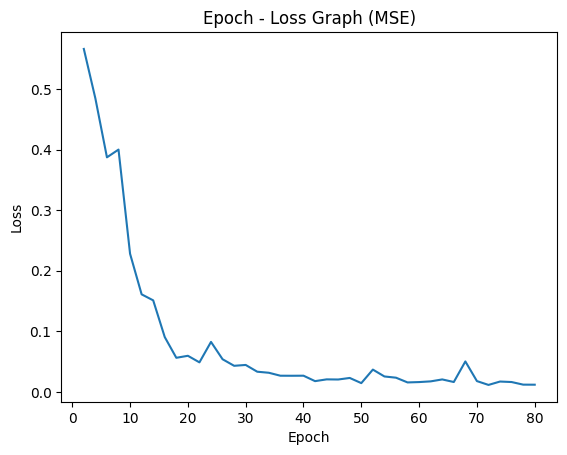

In [ ]:
class arguments:
  def __init__(args, LR_path, GT_path, epoch, scale, patch_size, in_memory, batch_size, num_workers, res_num, fine_tuning, pre_train_epoch, fine_train_epoch):
    args.LR_path = LR_path
    args.GT_path = GT_path
    args.epoch = epoch
    args.scale = scale
    args.patch_size = patch_size
    args.in_memory = in_memory
    args.batch_size = batch_size
    args.num_workers = num_workers
    args.res_num = res_num
    args.fine_tuning = fine_tuning
    args.pre_train_epoch = pre_train_epoch
    args.fine_train_epoch = fine_train_epoch

args = arguments('/content/drive/MyDrive/proyecto_final_ia/jupiter_2/LR','/content/drive/MyDrive/proyecto_final_ia/jupiter_2/HR', 80,4,24, True, 16,0,16, False, 80,4000)

print('Training model... \n')

train(args)